In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def handle_missing_remove(df):
    temp_df=df.copy()
    #Fill 0 in place of missing records for number of bedrooms,bathrooms,beds
    temp_df.beds.fillna(0,inplace=True)
    temp_df.bedrooms.fillna(0,inplace=True)
    temp_df.bathrooms.fillna(0,inplace=True)
    
    #Remove columns license and squarefeet which have more than 95% missing values
    temp_df.drop(['square_feet'], axis=1,inplace=True)
     
    return temp_df

In [3]:
def add_preprocess(df):
    
    temp_df = df.copy()
    temp_df = temp_df.replace(
            {
            'host_has_profile_pic': {'t': True, 'f': False},
            'host_identity_verified': {'t': True, 'f': False},
            'instant_bookable': {'t': True, 'f': False},
            }
    )
        
    ## Recode property_type
    def recode_prop(value):
        if value not in ['House', 'Apartment','Condominium','Townhouse','Loft']:
            return 'other_prop_type'
        return value

    temp_df['property_type'] = temp_df['property_type'].apply(recode_prop)

    ## Recode bed_type
    def recode_bed(value):
        if value not in ['Real Bed']:
            return 'other_bed_type'
        return value

    temp_df['bed_type'] = temp_df['bed_type'].apply(recode_bed)
        
    #Calculate the bedroom and bathroom share per person. Higher the share, more the comfort.
    temp_df = temp_df.assign(
        bedroom_share = temp_df.bedrooms/temp_df.accommodates,
        bathroom_share = temp_df.bathrooms/temp_df.accommodates)
    
    df = temp_df
    print("Additional pre-processing completed...")
    return df

In [4]:
def encoding (df):
    #Create dummy columns by one-hot encoding
    def create_dummies(df, columns = ['room_type', 'property_type', 'bed_type', 'cancellation_policy']):
        for column in columns:
            dummies = pd.get_dummies(df[column], prefix = column)
            df = pd.concat([df,dummies], axis = 1)
        return df
    
    df = create_dummies(df)
    # get amenities
    df.loc[df['amenities'] == '{}','amenities'] = ""
    #Remove the symbols and split the amenities with | as separator
    df['amenities'] = df['amenities'].map(
        lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                               for amn in amns.split(",")]))
    #Take the unique list of amenities across all listings
    amenities = np.unique(np.concatenate(df['amenities'].map(lambda amns: amns.split("|")).values))
    amenities_matrix = np.array([df['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
    #Make the amenities dataframe with boolean values
    amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)
    #Concat the listing id to amen dataframe
    df_amenities = pd.concat([amen, df['id']], axis=1)
    df_amenities = df_amenities.drop("", axis=1)
    amenity_recode={
                'Air Conditioning':'Weather Control',
                'Indoor Fireplace':'Weather Control',
                'Heating':'Weather Control',
        
                'Carbon Monoxide Detector':'Safety Features',
                'Fire Extinguisher':'Safety Features',
                'First Aid Kit':'Safety Features',
                'Smoke Detector':'Safety Features',
                
                'Buzzer/Wireless Intercom':'Security Features',
                'Doorman':'Security Features',
                'Safety Card':'Security Features',
                'Lock on Bedroom Door':'Security Features',
                
                'Cat(s)':'Pet Friendly',
                'Dog(s)':'Pet Friendly',
                'Pets Allowed':'Pet Friendly',
                'Pets live on this property':'Pet Friendly',
                'Other pet(s)':'Pet Friendly',
                
                'Elevator in Building':'Access Friendly',
                'Wheelchair Accessible':'Access Friendly',
                
                'Essentials':'Essentials',
                'Hair Dryer':'Essentials',
                'Hangers':'Essentials',
                'Iron':'Essentials',
                'Shampoo':'Essentials',             
                
                'Cable TV':'TV',
                'TV':'TV',
                
                'Internet':'Internet',
                'Wireless Internet':'Internet',
                'Laptop Friendly Workspace':'Internet',
                
                'Dryer':'Laundry Facility',
                'Washer':'Laundry Facility',
                'Washer / Dryer':'Laundry Facility'
}
    #Melt the amenities dataframe and recode from the dictionary
    df_amenities_melt = df_amenities.melt(id_vars=['id'], var_name='amenity')

    #Recoding and putting in new column called amenity_modified
    df_amenities_melt = df_amenities_melt.assign(
        amenity_modified = df_amenities_melt.amenity.replace(amenity_recode)
    )
    #Pivot the melted dataframe before merging with original dataframe
    df_amenities_pivot = df_amenities_melt.pivot_table(
        index='id',
        columns='amenity_modified',
        values='value', 
        aggfunc='max'
    )
    df_joined = df.join(df_amenities_pivot, on="id", how="inner")
    return df_joined

In [5]:
def randomforests (df):
    # train test split
    np.random.seed(2020)
    train = np.random.choice([True, False], df.shape[0], p=[0.8, 0.2])
    df_train = df.iloc[train,:]
    df_test = df.iloc[~train,:]
    train_cols = [
        'accommodates', 'beds','bathrooms',
        'bed_type_Real Bed',
        'property_type_Condominium','property_type_Townhouse',
        'room_type_Entire home/apt', 'room_type_Private room',
        'property_type_Apartment','property_type_House', 
        'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
        '24-Hour Check-in', 'Access Friendly', 'Breakfast', 'Essentials',
        'Family/Kid Friendly', 'Free Parking on Premises', 'Gym', 'Hot Tub',
        'Internet', 'Kitchen', 'Laundry Facility', 'Pet Friendly', 'Pool',
        'Safety Features', 'Security Features', 'Smoking Allowed',
        'Suitable for Events', 'TV', 'Weather Control']
    
    df_train.bathrooms.fillna(0, inplace = True)
    df_train.beds.fillna(0, inplace = True)
    df_test.bathrooms.fillna(0, inplace = True)
    df_test.beds.fillna(0, inplace = True)
    target_col = 'price'

    x_train = df_train[train_cols].values
    x_test = df_test[train_cols].values
    y_train = df_train[target_col].values
    y_test = df_test[target_col].values

    #Create a random forest regressor
    clf = RandomForestRegressor(max_depth= 7,
                                n_estimators= 67, 
                                criterion='mae', 
                                random_state= 47,
                                n_jobs= -1
                               )

    #Train the regressor
    clf.fit(x_train, y_train)

    #Plot variable importances for the top 10 predictors
    importances = clf.feature_importances_
    feat_names = train_cols
    tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
    tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')
    
     # Use the model to predict values
    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Training Data")
    print("R^2 value using score fn: %.3f" % r2_score(y_train, y_pred_train))
    print("Mean Squared Error : %0.3f" % mean_squared_error(y_train, y_pred_train))
    print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_train, y_pred_train))**0.5)

    print(" ----------------------------------- ")

   

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Test Data")
    print("R^2 value using score fn: %.3f" % r2_score(y_test, y_pred_test))
    print("Mean Squared Error : %0.3f" % mean_squared_error(y_test, y_pred_test))
    print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_test, y_pred_test))**0.5)

    print(" ----------------------------------- ")

    # Plot of model's residuals:
    fig = plt.figure(figsize=(10,3))

    sns.regplot((y_test),(y_pred_test), label = "test")
    sns.regplot((y_train), (y_pred_train), label = "train")
    plt.title("Residuals for the model")
    plt.xlabel("real price")
    plt.legend()
    plt.ylabel("predicted price")

Additional pre-processing completed...


D:\Application\Anaconda\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Training Data
R^2 value using score fn: 0.676
Mean Squared Error : 2677.701
Root Mean Squared Error : 51.747
 ----------------------------------- 
Test Data
R^2 value using score fn: 0.486
Mean Squared Error : 3945.251
Root Mean Squared Error : 62.811
 ----------------------------------- 


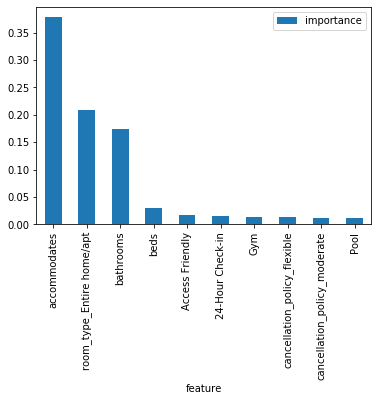

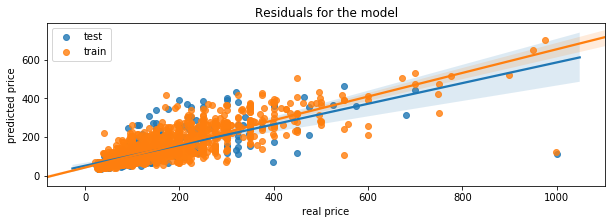

In [6]:
def main():
    df = pd.read_csv("listings_pred.csv")
    df = add_preprocess(df)
    df = encoding(df)
    randomforests(df)
if __name__ == '__main__':
    main()